In [1]:
import sys, os
import numpy as np
import time, h5py
codepath = '/user_data/mmhender/imStat/code'
sys.path.append(codepath)
from utils import default_paths, coco_utils, nsd_utils, numpy_utils 
from utils import stats_utils, segmentation_utils, prf_utils, texture_utils
from model_fitting import initialize_fitting 

import argparse
import pandas as pd
from skimage import io
import copy

from matplotlib import pyplot as plt
import PIL



Initializing coco api...
loading annotations into memory...
Done (t=0.58s)
creating index...
index created!
loading annotations into memory...
Done (t=15.89s)
creating index...
index created!
Initializing coco api...
loading annotations into memory...
Done (t=0.43s)
creating index...
index created!
loading annotations into memory...
Done (t=14.14s)
creating index...
index created!


In [3]:
# load basic things for a subject
subject = 1
ims = nsd_utils.get_image_data(subject, native=False)
subject_df = nsd_utils.get_subj_df(subject);
all_coco_ids = np.array(subject_df['cocoId'])


Loading images for subject 1

image data size: (10000, 3, 240, 240) , dtype: uint8 , value range: 0 255


things labels:
['vehicle']
['boat']
stuff labels:
['building', 'other', 'plant', 'sky', 'wall', 'water']
['building-other', 'grass', 'river', 'sky-other', 'tree', 'wall-concrete', 'other.1']


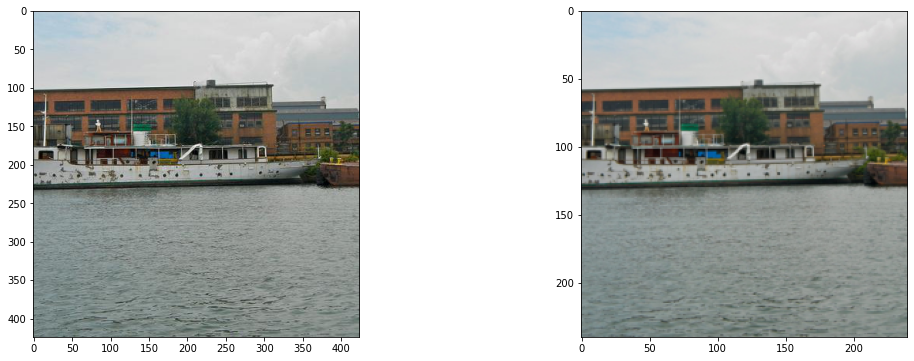

In [4]:
# Check the coco labels for example image

image_ind = np.random.choice(np.arange(0,10000), 1)[0]
# image_ind = 1

# Print things labels for the whole image
df = pd.read_csv(os.path.join(default_paths.stim_labels_root, \
                             'S%d_cocolabs_binary.csv'%subject), index_col=0)
supcat_names = list(df.keys())[0:12]
cat_names = list(df.keys()[12:92])

print('things labels:')
print([sname for sname in supcat_names if df[sname][image_ind]==1 ])
print([cname for cname in cat_names if df[cname][image_ind]==1 ])
 
# Print stuff labels for the whole image
df = pd.read_csv(os.path.join(default_paths.stim_labels_root, \
                             'S%d_cocolabs_stuff_binary.csv'%subject), index_col=0)
supcat_names = list(df.keys())[0:16]
cat_names = list(df.keys()[16:108])

print('stuff labels:')
print([sname for sname in supcat_names if df[sname][image_ind]==1 ])
print([cname for cname in cat_names if df[cname][image_ind]==1 ])
 
# loading the image from two different places to make sure it is the same one   
cocoid = np.array(subject_df['cocoId'])[image_ind]
cocoim = '/lab_data/tarrlab/common/datasets/NSD_images/images/%d.jpg'%cocoid
im = PIL.Image.open(cocoim)

plt.figure(figsize=(18,6));
plt.subplot(1,2,1)
plt.imshow(im)

plt.subplot(1,2,2)
plt.imshow(np.moveaxis(ims[image_ind,:,:,:],[0,1,2],[2,0,1]))

In [8]:
# Params for the spatial aspect of the model (possible pRFs)
which_prf_grid=5
models = initialize_fitting.get_prf_models(which_grid=which_prf_grid)    

In [10]:
np.unique(np.round(r[a==aa],4))

array([0.    , 0.0282, 0.0643, 0.1105, 0.1699, 0.2459, 0.3433, 0.4682,
       0.6282, 0.8333], dtype=float32)

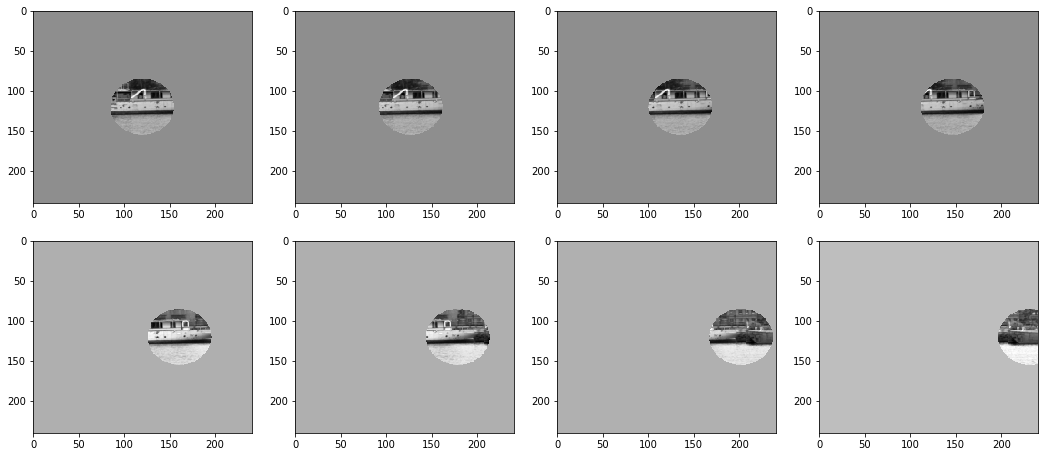

In [21]:
# Check pRF bounding boxes

plt.figure(figsize=(18,12));

sizes = np.unique(np.round(models[:,2],4))
r = np.sqrt(models[:,0]**2+models[:,1]**2)
a = np.mod(np.arctan2(models[:,1], models[:,0])*180/np.pi, 360)
ss = 3;
# aa = 67.5;
aa=0.0
rr_vals = np.unique(np.round(r[a==aa],4))

for ri, rr in enumerate(rr_vals):


    inds = np.where((a==aa) & (np.round(r,4)==rr) & (np.round(models[:,2],4)==sizes[ss]))[0]
    # inds = np.where(models)
#     prf_ind = 512;
    if len(inds)==0:
        continue
    prf_ind = inds[0]

    prf_params = models[prf_ind,:]    
    x,y,sigma = prf_params
    # n_pix = 240
    n_pix = ims.shape[2]
    aperture=1.0
    prf = prf_utils.gauss_2d(center=[x, y], sd=sigma, patch_size=n_pix, aperture=1.0, \
                                          dtype=np.float32)
    n_prf_sd_out = 2
    prf_bbox = texture_utils.get_bbox_from_prf(prf_params, (n_pix, n_pix), n_prf_sd_out, \
                                                       min_pix=None, verbose=False, force_square=False)


    middle_grey = 0.5;

    im = nsd_utils.image_uncolorize_fn(ims[image_ind:image_ind+1,:,:,:])
    im = im[0,0,:,:]


    plt.subplot(3,4,ri+1)

    prf_norm = prf/np.max(prf)

    # Creating a mask 2 SD from the center
    # cutoff of 0.14 approximates +/-2 SDs
    prf_mask = prf/np.max(prf)>0.14

#     im_mult = im*prf/np.max(prf)
    # im_mult[im_mult==0.0] = middle_grey
#     plt.pcolormesh(im_mult, cmap='gray')
#     plt.gca().invert_yaxis()

    im_masked = im*prf_mask
    im_masked[im_masked==0.0] = middle_grey

    plt.pcolormesh(im_masked, cmap='gray')
    plt.gca().invert_yaxis()

In [18]:
sizes = np.unique(np.round(models[:,2],4))
r = np.sqrt(models[:,0]**2+models[:,1]**2)
a = np.mod(np.arctan2(models[:,1], models[:,0])*180/np.pi, 360)
ss = 5;
# aa = 67.5;
aa=0.0
rr = np.unique(np.round(r[a==aa],4))[0]

inds = np.where((a==aa) & (np.round(r,4)==rr) & (np.round(models[:,2],4)==sizes[ss]))[0]
# inds = np.where(models)
# prf_ind = 512;
prf_ind = inds[0]

prf_params = models[prf_ind,:]    
x,y,sigma = prf_params
# n_pix = 240
n_pix = ims.shape[2]
aperture=1.0
prf = prf_utils.gauss_2d(center=[x, y], sd=sigma, patch_size=n_pix, aperture=1.0, \
                                      dtype=np.float32)
n_prf_sd_out = 2
prf_bbox = texture_utils.get_bbox_from_prf(prf_params, (n_pix, n_pix), n_prf_sd_out, \
                                                   min_pix=None, verbose=False, force_square=False)

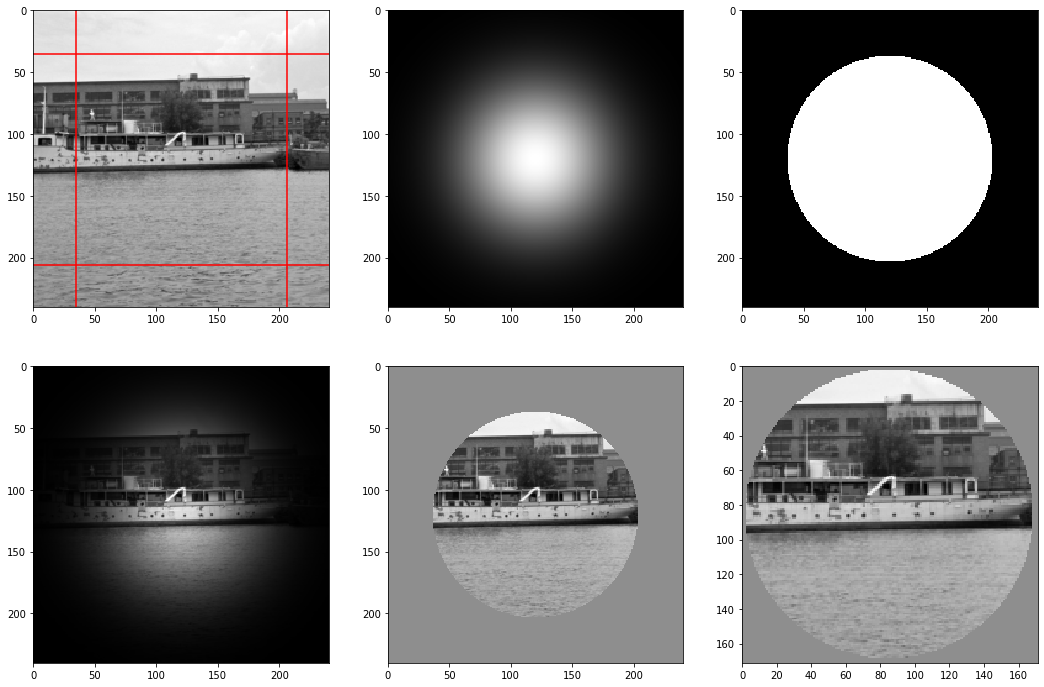

In [19]:
# Check pRF bounding boxes
middle_grey = 0.5;

im = nsd_utils.image_uncolorize_fn(ims[image_ind:image_ind+1,:,:,:])
im = im[0,0,:,:]

plt.figure(figsize=(18,12));
plt.subplot(2,3,1)
plt.pcolormesh(im, cmap='gray')
plt.gca().invert_yaxis()
# show the prf on top to make sure it is where it should be
plt.axhline([prf_bbox[0]],color='r')
plt.axhline([prf_bbox[1]],color='r')
plt.axvline([prf_bbox[2]],color='r')
plt.axvline([prf_bbox[3]],color='r')

plt.subplot(2,3,2)
prf_norm = prf/np.max(prf)
plt.pcolormesh(prf_norm, cmap='gray')
plt.gca().invert_yaxis()

# Creating a mask 2 SD from the center
# cutoff of 0.14 approximates +/-2 SDs
prf_mask = prf/np.max(prf)>0.14

plt.subplot(2,3,3)
plt.pcolormesh(prf_mask, cmap='gray')
plt.gca().invert_yaxis()

plt.subplot(2,3,4)
im_mult = im*prf/np.max(prf)
# im_mult[im_mult==0.0] = middle_grey
plt.pcolormesh(im_mult, cmap='gray')
plt.gca().invert_yaxis()

im_masked = im*prf_mask
im_masked[im_masked==0.0] = middle_grey

plt.subplot(2,3,5)
plt.pcolormesh(im_masked, cmap='gray')
plt.gca().invert_yaxis()

plt.subplot(2,3,6)
plt.pcolormesh(im_masked[prf_bbox[0]:prf_bbox[1], prf_bbox[2]:prf_bbox[3]], cmap='gray')
plt.gca().invert_yaxis()


In [20]:
# Load labels for this pRF, print

cat_objects, cat_names, cat_ids, supcat_names, ids_each_supcat = coco_utils.get_coco_cat_info(coco_utils.coco_val)
      
stuff_cat_objects, stuff_cat_names, stuff_cat_ids, stuff_supcat_names, stuff_ids_each_supcat = \
            coco_utils.get_coco_cat_info(coco_utils.coco_stuff_val)

things_df = pd.read_csv(os.path.join(default_paths.stim_labels_root, 'S%d_within_prf_grid%d'%(subject, which_prf_grid), \
                             'S%d_cocolabs_binary_prf%d.csv'%(subject, prf_ind)), index_col=0)
things_supcateg_labels = np.array(things_df)[:,0:12]
things_categ_labels = np.array(things_df)[:,12:92]

print('Super-ordinate things categories in pRF:')
print([supcat_names[n] for n in range(len(supcat_names)) \
       if things_supcateg_labels[image_ind,n]])

print('Sub-ordinate things categories in pRF:')
print([cat_names[n] for n in range(len(cat_names)) if things_categ_labels[image_ind,n]])

stuff_df = pd.read_csv(os.path.join(default_paths.stim_labels_root, 'S%d_within_prf_grid%d'%(subject, which_prf_grid), \
                             'S%d_cocolabs_stuff_binary_prf%d.csv'%(subject, prf_ind)), index_col=0)
stuff_supcateg_labels = np.array(stuff_df)[:,0:16]
stuff_categ_labels = np.array(stuff_df)[:,16:108]

print('Super-ordinate stuff categories in pRF:')
print([stuff_supcat_names[n] for n in range(len(stuff_supcat_names)) \
       if stuff_supcateg_labels[image_ind,n]])

print('Sub-ordinate stuff categories in pRF:')
print([stuff_cat_names[n] for n in range(len(stuff_cat_names)) if stuff_categ_labels[image_ind,n]])

Super-ordinate things categories in pRF:
['vehicle']
Sub-ordinate things categories in pRF:
['boat']
Super-ordinate stuff categories in pRF:
['building', 'other', 'plant', 'sky', 'water']
Sub-ordinate stuff categories in pRF:
['building-other', 'river', 'sky-other', 'tree', 'other']
